# Hydrological Data Colection Center
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 04-09-2024<br>

**Introduction:**<br>
This code downloads the reservoir time series available in the HYDRO data base in Spain.

In [18]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import Point
import re
import requests
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from lisfloodreservoirs.utils import DatasetConfig, APIConfig

## Configuration

In [20]:
# dataset cofiguration
cfg = DatasetConfig('config_dataset.yml')

# HDMS API configuration
api = APIConfig('../HDMS_API.yml')

# provider of interes
PROVIDER_ID = 1088 # CEDEX

# study period
strftime = '%Y-%m-%dT%H:%M:%S'

# variables of interest
VARIABLES = {
    'O': 'outflow',
    'V': 'volume',
    'R': 'level'
}

# directory of the HDMS dataset
PATH_HDMS = Path('Z:/nahaUsers/casadje/datasets/hDMS/reservoirs')

## Reservoirs

Import CSV file of reservoirs in the Hydrological Data Colection Center (HDCC) database, fix some reservoir names and export it as a shapefile.

```Python
reservoirs = pd.read_csv(list(PATH_HDMS.glob('*.csv'))[0], sep=';', index_col='EFAS_ID')

# correct reservoir names
names = []
for name in reservoirs.Name:
    name = name.upper()
    # remove code from reservoir name
    name = re.sub(r'E\d{2}\s*', '', name)
    # remove string 'embalse' from name
    name = re.sub(r'EMBALSE DE\s+', '', name)
    name = re.sub(r'EMBALSE DEL\s+', 'EL ', name)
    # remove string at the of the name
    name = re.sub(r'\s*\(PIE DE PRESA\)', '', name)
    # place articles ('el', 'la'...) at the beginning
    name = re.sub(r'(\w+), (\w+)', r'\2 \1', name)
    names.append(name)
reservoirs.Name = names

# convert into GeoDataFrame
geometry = [Point(xy) for xy in zip(reservoirs.Longitude_WGS84, reservoirs.Latitude_WGS84)]
reservoirs = gpd.GeoDataFrame(reservoirs, geometry=geometry, crs='epsg:4326')

print('total no. reservoirs:\t\t\t{0}'.format(reservoirs.shape[0]))

reservoirs.to_file('Z:/nahaUsers/casadje/datasets/hDMS/reservoirs/reservoirs.shp')
```

394 reservoirs with 141 attributes


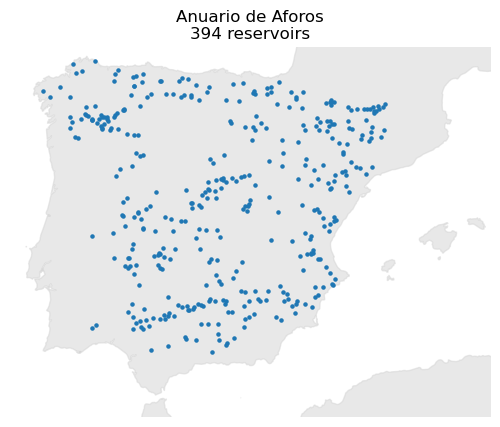

In [3]:
# import shapefile
hdcc = gpd.read_file(PATH_HDMS / 'reservoirs.shp')
hdcc.set_index('EFAS_ID', drop=True, inplace=True)
hdcc.index = hdcc.index.astype(int)

# correct reservoir names
names = []
for name in hdcc.Name:
    name = name.upper()
    # remove code from reservoir name
    name = re.sub(r'E\d{2}\s*', '', name)
    # remove string 'embalse' from name
    name = re.sub(r'EMBALSE DE\s+', '', name)
    name = re.sub(r'EMBALSE DEL\s+', 'EL ', name)
    # remove string at the of the name
    name = re.sub(r'\s*\(PIE DE PRESA\)', '', name)
    # place articles ('el', 'la'...) at the beginning
    name = re.sub(r'(\w+), (\w+)', r'\2 \1', name)
    names.append(name)
hdcc.Name = names

# rename columns
hdcc.rename(columns={'Provider_I': 'Prov_ID'}, inplace=True)

# filter reservoirs from the Spanish Ministry
hdcc_es = hdcc.loc[hdcc['Country-Co'] == 'ES'].copy()
hdcc_es = hdcc.loc[hdcc.Prov_ID == str(PROVIDER_ID)]

print('{0} reservoirs with {1} attributes'.format(*hdcc_es.shape))

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
hdcc_es.plot(markersize=5, ax=ax)
ax.set_title(f'Anuario de Aforos\n{hdcc_es.shape[0]} reservoirs')
ax.set_extent([-10, 4.5, 35.5, 44])
ax.axis('off');

In [4]:
# summarize data availability
data_cols = hdcc_es.columns[hdcc.columns.str.contains('[O|V|R]_Has_')].tolist()
hdcc_es[data_cols].astype(bool).sum()

O_Has_RTDa    376
O_Has_hist    376
O_Has_Pote    376
O_Has_Oper    376
R_Has_RTDa      0
R_Has_hist      0
R_Has_Pote      0
R_Has_Oper      0
V_Has_RTDa    389
V_Has_hist    389
V_Has_Pote    389
V_Has_Oper    389
dtype: int64

Outflow ($O$) and volume ($V$) time series are available in 376 and 389 reservoirs, respectively. In both variables the number of reservoirs with real time, historical and operational data are identical.

## Download data

### Data range

```Python
service = 'hdatarange'
url = f'{api.URL}/{service}/'
response = requests.get(url + '9142', auth=requests.auth.HTTPBasicAuth(api.USERNAME, api.PASSWORD))

if response.status_code == 200:
    data = response.json()
    # Do something with the data
else:
    print("Failed to retrieve data from the API")
```

In [5]:
date_cols = hdcc_es.columns[hdcc_es.columns.str.contains('Date_of_[Starting|Ending]')]
hdcc_es.shape[0] - hdcc_es.loc[:, date_cols].isnull().sum()

Date_of_St    0
Date_of_En    0
dtype: int64

All of the fields with beginning and end of the time series are empty.

### Operational

In [14]:
service = 'nhoperational24hw'

# data must be downloaded in 4 batches due to server limitations
dates = [date.date() for date in pd.date_range(cfg.START, cfg.END, periods=4)]

# path where the data will be saved
path_out = PATH_HDMS / service
path_out.mkdir(parents=True, exist_ok=True)

for ID in tqdm(hdcc_es.index, desc='reservoir'):
    
    file_out = path_out / f'{ID}.nc'
    if file_out.exists():
        continue
    
    # download data
    data = {}
    for var, variable in VARIABLES.items(): # for each variable
        if 'serie' in locals():
            del serie
        serie = pd.DataFrame(columns=[ID], dtype=float)
        for i, (st, en) in enumerate(zip(dates[:-1], dates[1:])): # for each batch
            if i > 0:
                st += timedelta(days=1)           
            url = f'{api.URL}/{service}/{st.strftime(strftime)}/{en.strftime(strftime)}/{ID}/{var}/'
            response = requests.get(url, auth=requests.auth.HTTPBasicAuth(api.USERNAME, api.PASSWORD))
            if response.status_code == 200:
                serie_i = pd.DataFrame(response.json())
                if serie_i.shape[0] > 0:
                    serie_i = serie_i[['Timestamp', 'AvgValue']].set_index('Timestamp', drop=True)
                    serie_i.index = pd.to_datetime(serie_i.index)
                    serie_i.columns = [ID]
                    serie = pd.concat((serie, serie_i), axis=0)
        if serie.shape[0] > 0:
            data[variable] = serie.sort_index().copy()
        
    if len(data) > 0:
        
        # convert to xarray.Dataset
        data = xr.Dataset({var: xr.DataArray(serie, dims=['date', 'ID']) for var, serie in data.items()})
        
        # export as NetCDF
        data.to_netcdf(file_out)
    else:
        print(f'No data was found for reservoir {ID}')

reservoir:   0%|          | 0/394 [00:00<?, ?it/s]

No data was found for reservoir 9126
No data was found for reservoir 9127
No data was found for reservoir 9128
No data was found for reservoir 9129
No data was found for reservoir 9130
No data was found for reservoir 9131
No data was found for reservoir 9132
No data was found for reservoir 9133
No data was found for reservoir 9134
No data was found for reservoir 9135
No data was found for reservoir 9136
No data was found for reservoir 9137
No data was found for reservoir 9138
No data was found for reservoir 9139
No data was found for reservoir 9140
No data was found for reservoir 9141
No data was found for reservoir 9142
No data was found for reservoir 9143
No data was found for reservoir 9144
No data was found for reservoir 9145
No data was found for reservoir 9146
No data was found for reservoir 9147
No data was found for reservoir 9148
No data was found for reservoir 9149
No data was found for reservoir 9150
No data was found for reservoir 9151
No data was found for reservoir 9152
N

KeyboardInterrupt: 